# Tutorial 1: Introduction to Spectral Matching and Response Spectra

**Duration:** ~30-40 minutes

## Learning Objectives

By the end of this tutorial, you will understand:

1. **Why spectral matching matters** in earthquake engineering
2. **What a response spectrum is** and how to interpret it
3. **How structures respond** to earthquake ground motion
4. **The spectral matching problem** and why simple scaling is insufficient

---

## Prerequisites

- Basic Python programming
- Understanding of derivatives and integrals (calculus)
- Familiarity with NumPy and Matplotlib is helpful but not required

---

## Section 1: Why Spectral Matching Matters

### The Real-World Challenge

Imagine you're a structural engineer designing a hospital in California. This building **must remain functional** after a major earthquake to serve the community during a disaster. How do you ensure your design is safe?

You need to test how the structure responds to earthquakes. But here's the problem:

1. **Every earthquake is unique** - Different magnitudes, distances, soil conditions
2. **You can't wait for the next big earthquake** to test your design
3. **Building codes provide target requirements** - Not actual earthquake records

### The Solution: Spectral Matching

**Spectral matching** allows you to:
- Take an existing earthquake record (like the 1940 El Centro earthquake)
- Modify it to match building code requirements for your specific site
- Preserve the realistic time-domain characteristics of the motion

**Analogy:** Think of it like adjusting a recipe's ingredients to achieve target nutritional values (protein, calories, vitamins) while keeping the dish edible and realistic. You wouldn't just scale all ingredients by the same factor - you'd carefully adjust different components.

### What We'll Learn

This tutorial series will teach you two methods for spectral matching:
1. **Iterative FFT Matching** - Adjusts the frequency content
2. **Greedy Wavelet Matching** - Adds targeted time-domain corrections

Let's start by understanding what makes earthquakes affect structures differently.

---

## Setup: Import Libraries and Configure Paths

First, let's import the necessary libraries and set up our environment.

In [1]:
# Standard scientific computing libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import windows
import sys
import os

# Configure matplotlib for nice plots
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['lines.linewidth'] = 1.5

# Add the spectral_matching package to Python path
sys.path.insert(0, os.path.abspath('../src'))

# Import spectral matching functions
from spectral_matching import (
    load_acceleration_record,
    load_target_spectrum,
    response_spectrum,
    piecewise_exact_solver,
    scale_to_target_band,
    baseline_correction
)

print("✓ Libraries loaded successfully!")
print("✓ Spectral matching package imported!")

✓ Libraries loaded successfully!
✓ Spectral matching package imported!


---

## Section 2: Loading and Visualizing an Earthquake Record

Let's start by loading a famous earthquake: the **1940 El Centro earthquake** (North-South component). This magnitude 6.9 earthquake was recorded in Imperial Valley, California and is one of the most widely used records in earthquake engineering.

In [2]:
# Load the El Centro earthquake record
time, acceleration, dt = load_acceleration_record("../src/data/elcentro_NS.dat.txt")

# Print basic information
print("El Centro 1940 Earthquake (North-South Component)")
print("="*50)
print(f"Duration: {time[-1]:.2f} seconds")
print(f"Time step (Δt): {dt:.4f} seconds")
print(f"Number of data points: {len(acceleration)}")
print(f"Peak Ground Acceleration (PGA): {np.max(np.abs(acceleration)):.3f} m/s²")

El Centro 1940 Earthquake (North-South Component)
Duration: 53.74 seconds
Time step (Δt): 0.0200 seconds
Number of data points: 2688
Peak Ground Acceleration (PGA): 3.420 m/s²


### Visualizing the Ground Motion

Now let's see what this earthquake looks like in the time domain. This is the actual ground acceleration recorded during the earthquake.

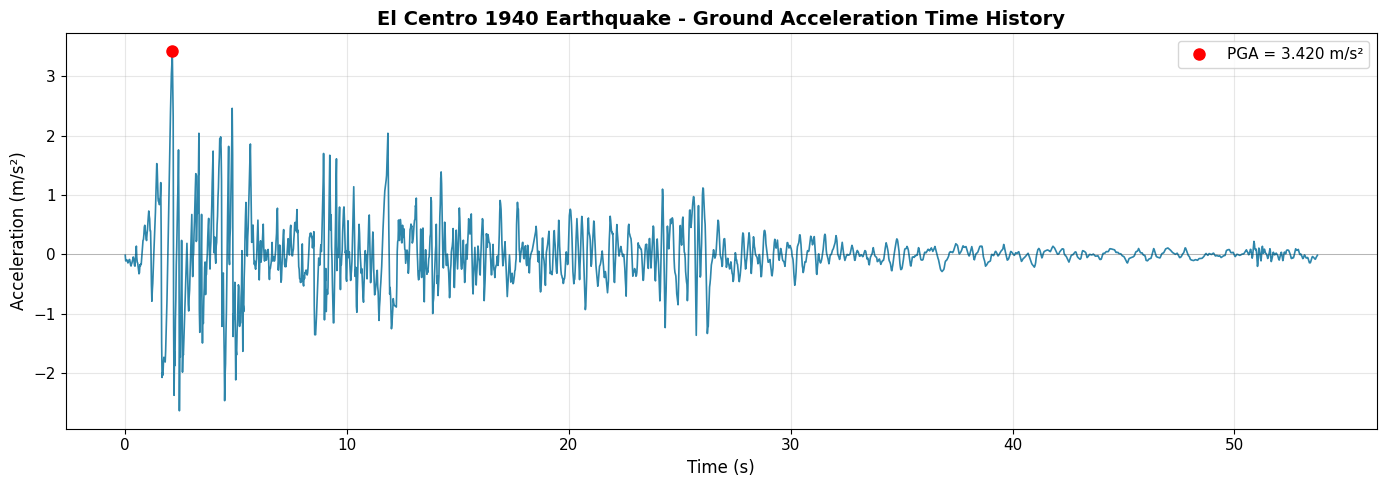


💡 Key Observation:
Notice how the earthquake has strong shaking phases (peaks) and quieter periods.
The strongest shaking occurs around t = 2.1 seconds.


In [3]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(time, acceleration, color='#2E86AB', linewidth=1.2)
ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)

# Highlight the peak ground acceleration
pga_index = np.argmax(np.abs(acceleration))
pga_time = time[pga_index]
pga_value = acceleration[pga_index]
ax.plot(pga_time, pga_value, 'ro', markersize=8, label=f'PGA = {abs(pga_value):.3f} m/s²')

ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Acceleration (m/s²)', fontsize=12)
ax.set_title('El Centro 1940 Earthquake - Ground Acceleration Time History', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', fontsize=11)
plt.tight_layout()
plt.show()

print("\n💡 Key Observation:")
print("Notice how the earthquake has strong shaking phases (peaks) and quieter periods.")
print("The strongest shaking occurs around t = {:.1f} seconds.".format(pga_time))

---

## Section 3: Understanding Response Spectra - The Frequency Signature

### The Core Question

Looking at the time history above, we see the ground shaking. But **how does a building respond** to this motion?

The key insight: **Different structures respond differently to the same earthquake.**

**Analogy:** Think of singing into a room with musical instruments:
- A guitar string tuned to C might vibrate strongly
- A different string tuned to F# might barely move
- Each instrument resonates at its own frequencies

Similarly:
- A tall flexible building (long period, ~2-3 seconds) responds more to low frequencies
- A short stiff building (short period, ~0.2-0.5 seconds) responds more to high frequencies

### The Single-Degree-of-Freedom (SDOF) System

To understand how structures respond, we model them as simple **mass-spring-damper systems**:

```
        ┌─────┐  
        │  M  │  ← Mass (building)
        └──┬──┘  
           │ ╱╲  
           │╱  ╲ ← Spring (stiffness)
          ─┴────╱ ← Damper (energy dissipation)
    ════════════════ ← Ground (input motion)
```

The equation of motion for this system is:

$$u''(t) + 2\zeta\omega_n u'(t) + \omega_n^2 u(t) = -a_g(t)$$

Where:
- $u(t)$ = displacement of mass relative to ground
- $u'(t)$ = velocity, $u''(t)$ = acceleration
- $a_g(t)$ = ground acceleration (the earthquake)
- $\omega_n = 2\pi/T$ = natural frequency (rad/s)
- $T$ = natural period (seconds) - **the key parameter**
- $\zeta$ = damping ratio (typically 5% = 0.05 for concrete buildings)

**Plain English:**
- Left side: How the mass moves (inertia + damping + stiffness forces)
- Right side: The earthquake shaking the ground

### What is the Natural Period T?

The **natural period** is the time it takes for the structure to complete one cycle of free vibration.

**Rule of thumb for buildings:**
- $T \approx 0.1 \times N$ seconds, where $N$ = number of stories
- 5-story building: $T \approx 0.5$ seconds
- 20-story building: $T \approx 2.0$ seconds

---

### Example: Response of a Single Structure

Let's see how a **5-story building** (period $T = 0.5$ seconds) responds to the El Centro earthquake.

In [4]:
# Define the structural properties
T_structure = 0.5  # Natural period (seconds) - typical for 5-story building
omega_n = 2 * np.pi / T_structure  # Natural frequency (rad/s)
damping = 0.05  # 5% damping (typical for concrete)

# Solve the SDOF equation to get the structure's response
# This returns the absolute acceleration of the mass
response_acceleration = piecewise_exact_solver(
    acceleration,  # Ground acceleration input
    dt,           # Time step
    omega_n,      # Natural frequency
    damping       # Damping ratio
)

# The spectral acceleration is the peak absolute acceleration
Sa = np.max(np.abs(response_acceleration))

print(f"Structure: 5-story building (T = {T_structure} s)")
print(f"Peak ground acceleration: {np.max(np.abs(acceleration)):.3f} m/s²")
print(f"Peak structural response: {Sa:.3f} m/s²")
print(f"\nAmplification factor: {Sa / np.max(np.abs(acceleration)):.2f}x")
print("\n💡 Notice: The building experiences higher acceleration than the ground!")
print("This is resonance - the structure amplifies the ground motion.")

Structure: 5-story building (T = 0.5 s)
Peak ground acceleration: 3.420 m/s²
Peak structural response: 8.198 m/s²

Amplification factor: 2.40x

💡 Notice: The building experiences higher acceleration than the ground!
This is resonance - the structure amplifies the ground motion.


Let's visualize both the ground motion and the structural response:

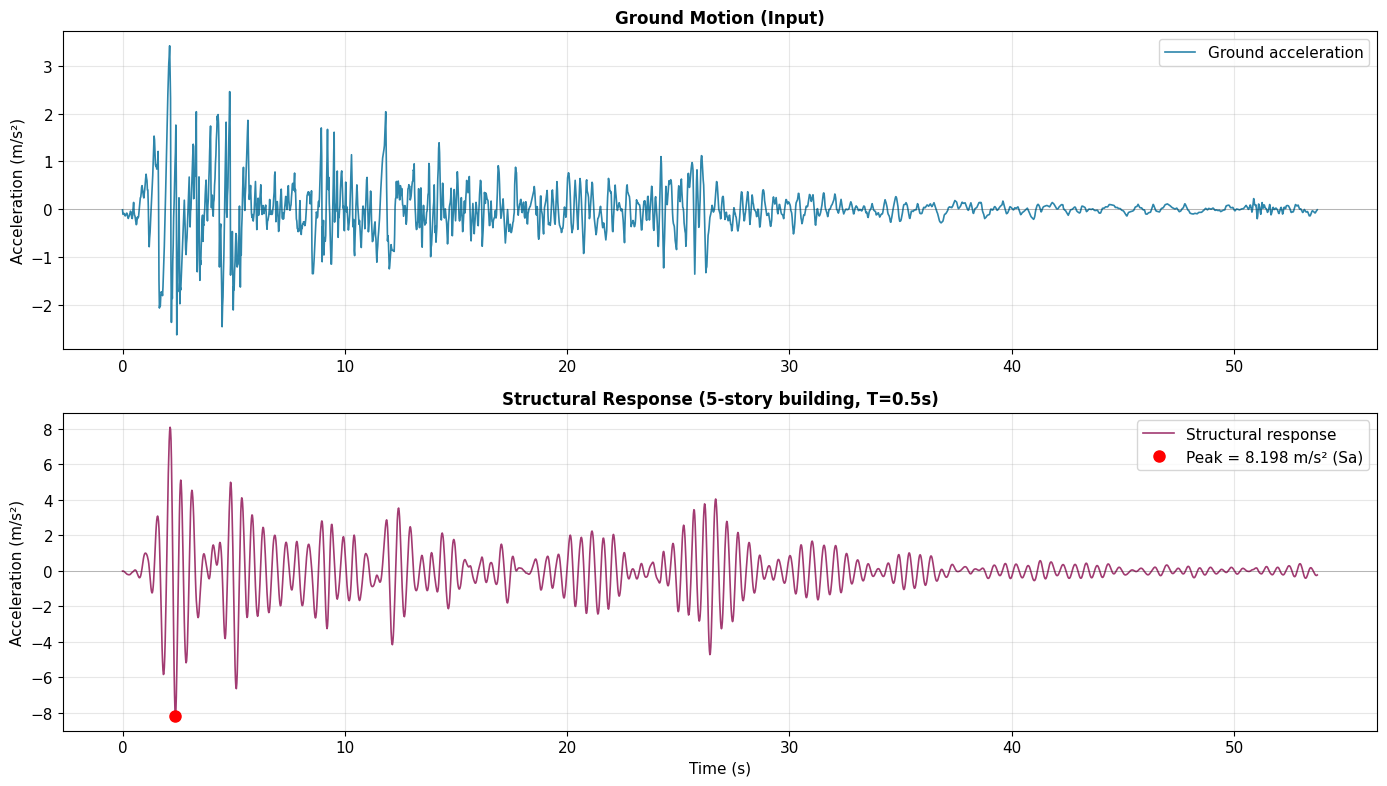


💡 Key Observations:
1. The structural response has oscillations characteristic of the building's natural period
2. The peak structural response is amplified compared to ground motion
3. Response continues even after strong ground shaking stops (free vibration)


In [5]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot ground acceleration
axes[0].plot(time, acceleration, color='#2E86AB', linewidth=1.2, label='Ground acceleration')
axes[0].axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
axes[0].set_ylabel('Acceleration (m/s²)', fontsize=11)
axes[0].set_title('Ground Motion (Input)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='upper right')

# Plot structural response
axes[1].plot(time, response_acceleration, color='#A23B72', linewidth=1.2, label='Structural response')
axes[1].axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)

# Mark the peak response
peak_idx = np.argmax(np.abs(response_acceleration))
axes[1].plot(time[peak_idx], response_acceleration[peak_idx], 'ro', markersize=8,
            label=f'Peak = {abs(response_acceleration[peak_idx]):.3f} m/s² (Sa)')

axes[1].set_xlabel('Time (s)', fontsize=11)
axes[1].set_ylabel('Acceleration (m/s²)', fontsize=11)
axes[1].set_title('Structural Response (5-story building, T=0.5s)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

print("\n💡 Key Observations:")
print("1. The structural response has oscillations characteristic of the building's natural period")
print("2. The peak structural response is amplified compared to ground motion")
print("3. Response continues even after strong ground shaking stops (free vibration)")

---

## Section 4: Building the Response Spectrum

### The Big Idea

We just computed the response for **one** building (T = 0.5s). But what about buildings with different periods?

The **response spectrum** is created by:
1. Considering many imaginary SDOF structures with different periods
2. Computing each one's peak response to the earthquake
3. Plotting peak response vs. period

**Result:** A curve that shows which building periods experience the strongest shaking.

### Computing the Full Response Spectrum

In [6]:
# Create an array of periods from 0.05s to 3.0s
# This covers the range from very stiff (short) to very flexible (tall) structures
periods = np.linspace(0.05, 3.0, 300)

# Compute the response spectrum using our package
# This computes the peak response for each period
spectrum = response_spectrum(
    acceleration,  # Ground motion
    dt,           # Time step
    periods,      # Array of periods to evaluate
    damping=0.05  # 5% damping
)

print("Response spectrum computed!")
print(f"Evaluated at {len(periods)} period points")
print(f"Period range: {periods[0]:.2f}s to {periods[-1]:.2f}s")

# Find the period with maximum spectral acceleration
max_idx = np.argmax(spectrum)
print(f"\nMaximum spectral acceleration: {spectrum[max_idx]:.3f} m/s²")
print(f"Occurs at period: {periods[max_idx]:.3f} seconds")
print(f"\n💡 Buildings with periods near {periods[max_idx]:.2f}s will experience the strongest shaking!")

Response spectrum computed!
Evaluated at 300 period points
Period range: 0.05s to 3.00s

Maximum spectral acceleration: 9.033 m/s²
Occurs at period: 0.257 seconds

💡 Buildings with periods near 0.26s will experience the strongest shaking!


### Visualizing the Response Spectrum

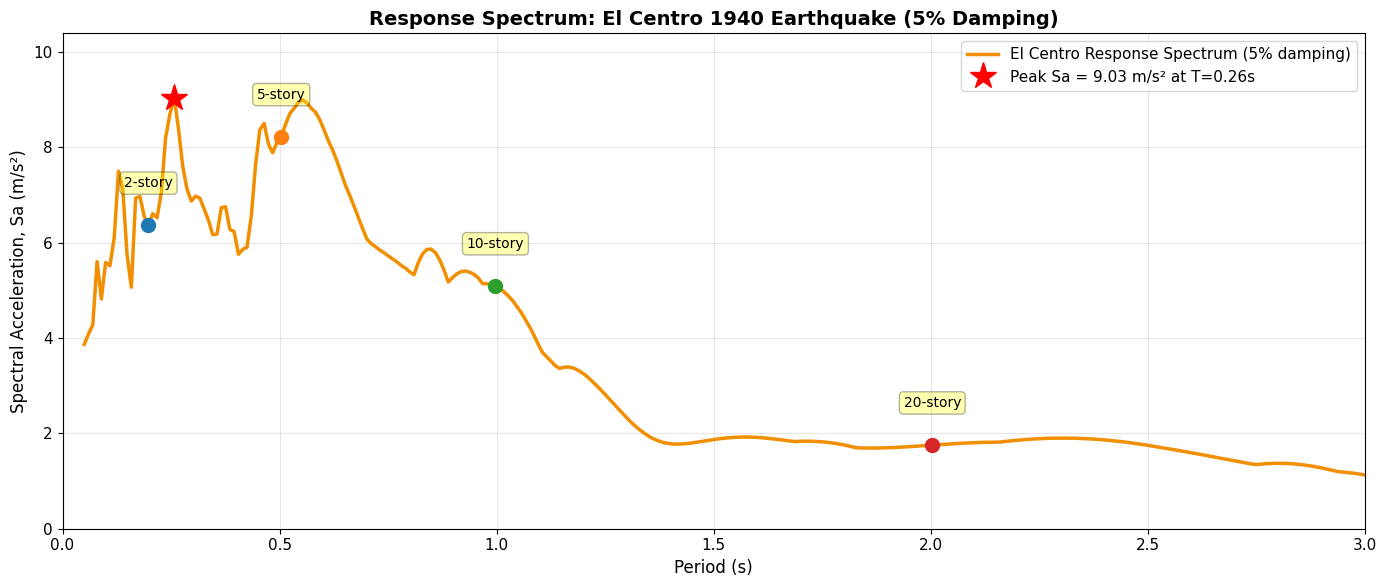


💡 How to Read This Plot:
- X-axis: Building natural period (structural characteristic)
- Y-axis: Maximum acceleration the building experiences
- Peak region: Buildings with these periods will shake the hardest
- This is the 'frequency signature' of the earthquake


In [7]:
fig, ax = plt.subplots(figsize=(14, 6))

# Plot the response spectrum
ax.plot(periods, spectrum, color='#F18F01', linewidth=2.5, label='El Centro Response Spectrum (5% damping)')

# Mark some representative building types
building_types = [
    (0.2, "2-story"),
    (0.5, "5-story"),
    (1.0, "10-story"),
    (2.0, "20-story")
]

for period, label in building_types:
    # Find closest period in our array
    idx = np.argmin(np.abs(periods - period))
    ax.plot(periods[idx], spectrum[idx], 'o', markersize=10)
    ax.annotate(label, xy=(periods[idx], spectrum[idx]), 
               xytext=(periods[idx], spectrum[idx] + 0.8),
               ha='center', fontsize=10,
               bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

# Highlight the peak
ax.plot(periods[max_idx], spectrum[max_idx], 'r*', markersize=20, 
       label=f'Peak Sa = {spectrum[max_idx]:.2f} m/s² at T={periods[max_idx]:.2f}s')

ax.set_xlabel('Period (s)', fontsize=12)
ax.set_ylabel('Spectral Acceleration, Sa (m/s²)', fontsize=12)
ax.set_title('Response Spectrum: El Centro 1940 Earthquake (5% Damping)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', fontsize=11)
ax.set_xlim([0, 3])
ax.set_ylim([0, max(spectrum) * 1.15])
plt.tight_layout()
plt.show()

print("\n💡 How to Read This Plot:")
print("- X-axis: Building natural period (structural characteristic)")
print("- Y-axis: Maximum acceleration the building experiences")
print("- Peak region: Buildings with these periods will shake the hardest")
print("- This is the 'frequency signature' of the earthquake")

---

## Section 5: The Spectral Matching Problem

### The Challenge

Now that we understand response spectra, let's see the problem that spectral matching solves.

**Scenario:** Building codes provide a **target response spectrum** based on:
- Site seismicity (earthquake hazard)
- Local soil conditions
- Building importance

This target spectrum represents the design earthquake your building must withstand.

**Question:** How do we modify our El Centro record to match this target?

Let's load a target spectrum and see the mismatch:

Target spectrum loaded!
Target represents: Design-level earthquake for site


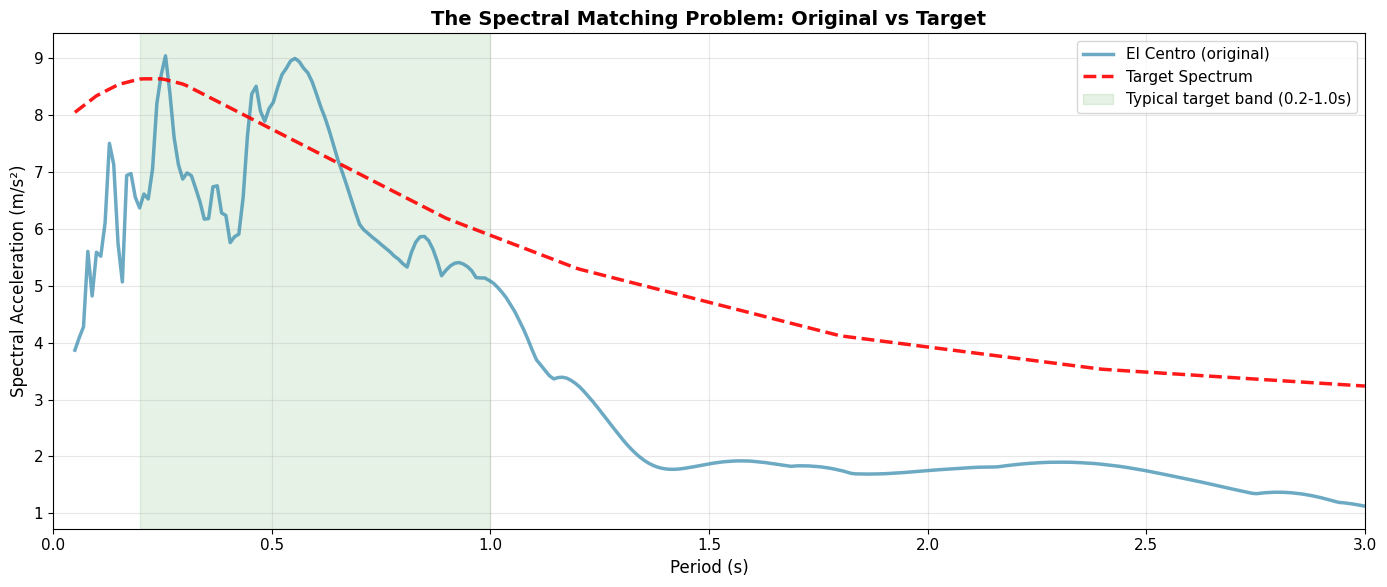


💡 The Gap:
The original El Centro record doesn't match the target spectrum.
Some periods are too high, others too low.
We need to modify the record to match the target, especially in the green band.


In [8]:
# Load target spectrum (e.g., Uniform Hazard Spectrum for the site)
periods_target, target_spectrum = load_target_spectrum(
    "../src/data/uhs_el_centro.csv",
    periods  # Use same period points
)

print("Target spectrum loaded!")
print(f"Target represents: Design-level earthquake for site")

# Compare the spectra
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(periods, spectrum, color='#2E86AB', linewidth=2.5, label='El Centro (original)', alpha=0.7)
ax.plot(periods_target, target_spectrum, color='red', linewidth=2.5, 
       linestyle='--', label='Target Spectrum', alpha=0.9)

# Shade a typical target period band (0.2-1.0s)
ax.axvspan(0.2, 1.0, alpha=0.1, color='green', label='Typical target band (0.2-1.0s)')

ax.set_xlabel('Period (s)', fontsize=12)
ax.set_ylabel('Spectral Acceleration (m/s²)', fontsize=12)
ax.set_title('The Spectral Matching Problem: Original vs Target', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', fontsize=11)
ax.set_xlim([0, 3])
plt.tight_layout()
plt.show()

print("\n💡 The Gap:")
print("The original El Centro record doesn't match the target spectrum.")
print("Some periods are too high, others too low.")
print("We need to modify the record to match the target, especially in the green band.")

### Why Not Just Scale?

The simplest approach is to multiply the entire acceleration by a constant factor:

$$a_{\text{scaled}}(t) = \alpha \cdot a_{\text{original}}(t)$$

Let's try this:

In [9]:
# Apply baseline correction first (removes drift)
acceleration_corrected = baseline_correction(acceleration, time, order=2)

# Scale to match target in the band 0.2-1.0s
acceleration_scaled, scale_factor = scale_to_target_band(
    acceleration_corrected,
    dt,
    periods,
    target_spectrum,
    band=[0.2, 1.0],  # Focus on this period range
    damping=0.05
)

# Compute spectrum of scaled record
spectrum_scaled = response_spectrum(acceleration_scaled, dt, periods, damping=0.05)

print(f"Applied scale factor: {scale_factor:.3f}")
print(f"Original PGA: {np.max(np.abs(acceleration)):.3f} m/s²")
print(f"Scaled PGA: {np.max(np.abs(acceleration_scaled)):.3f} m/s²")

Applied scale factor: 1.109
Original PGA: 3.420 m/s²
Scaled PGA: 3.786 m/s²


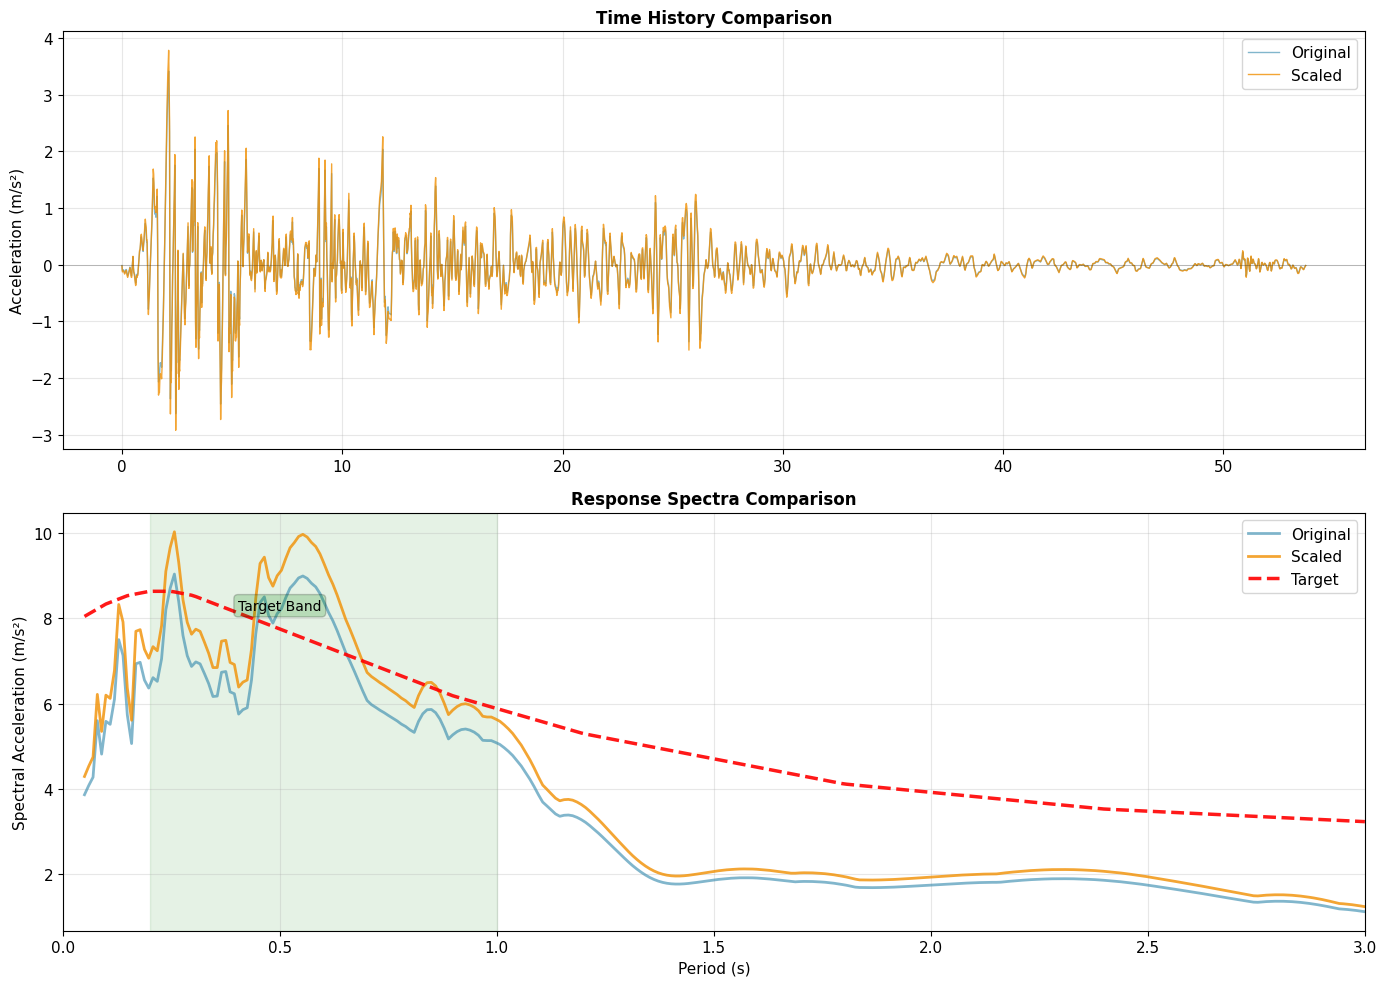


Match quality in target band (0.2-1.0s):
  Match percentage: 88.5%
  Mean error: 11.5%
  Maximum error: 32.2%

⚠️  Limitation of Scaling:
Simple scaling can't achieve a tight match (~95%+ required).
We need selective frequency adjustment - that's what spectral matching does!


In [10]:
# Visualize the result of scaling
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Top: Time histories
axes[0].plot(time, acceleration, color='#2E86AB', linewidth=1, alpha=0.6, label='Original')
axes[0].plot(time, acceleration_scaled, color='#F18F01', linewidth=1, alpha=0.8, label='Scaled')
axes[0].axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
axes[0].set_ylabel('Acceleration (m/s²)', fontsize=11)
axes[0].set_title('Time History Comparison', fontsize=12, fontweight='bold')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# Bottom: Response spectra
axes[1].plot(periods, spectrum, color='#2E86AB', linewidth=2, alpha=0.6, label='Original')
axes[1].plot(periods, spectrum_scaled, color='#F18F01', linewidth=2, alpha=0.8, label='Scaled')
axes[1].plot(periods_target, target_spectrum, 'r--', linewidth=2.5, label='Target', alpha=0.9)
axes[1].axvspan(0.2, 1.0, alpha=0.1, color='green')
axes[1].text(0.5, max(target_spectrum)*0.95, 'Target Band', ha='center', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='green', alpha=0.2))
axes[1].set_xlabel('Period (s)', fontsize=11)
axes[1].set_ylabel('Spectral Acceleration (m/s²)', fontsize=11)
axes[1].set_title('Response Spectra Comparison', fontsize=12, fontweight='bold')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([0, 3])

plt.tight_layout()
plt.show()

# Compute match quality in the target band
band_mask = (periods >= 0.2) & (periods <= 1.0)
error = np.abs(spectrum_scaled[band_mask] - target_spectrum[band_mask]) / target_spectrum[band_mask]
mean_error = np.mean(error) * 100
max_error = np.max(error) * 100

# Approximate match percentage
match_pct = 100 - mean_error

print(f"\nMatch quality in target band (0.2-1.0s):")
print(f"  Match percentage: {match_pct:.1f}%")
print(f"  Mean error: {mean_error:.1f}%")
print(f"  Maximum error: {max_error:.1f}%")
print(f"\n⚠️  Limitation of Scaling:")
print(f"Simple scaling can't achieve a tight match (~95%+ required).")
print(f"We need selective frequency adjustment - that's what spectral matching does!")

---

## Section 6: Summary and Key Takeaways

### What We Learned

1. **Spectral matching is essential** for creating earthquake records that meet building code requirements

2. **Response spectra capture frequency content**:
   - Each point represents a different imaginary building (SDOF system)
   - The height shows peak acceleration that building experiences
   - It's the "fingerprint" of an earthquake's frequency signature

3. **The SDOF system** is the fundamental building block:
   - Mass-spring-damper system
   - Characterized by natural period T
   - Different periods respond differently to same ground motion

4. **Simple scaling is insufficient**:
   - Scales all frequencies uniformly
   - Can't achieve tight spectral match
   - Typically achieves only 80-90% match

5. **We need sophisticated methods** that can:
   - Selectively adjust different frequency ranges
   - Maintain physical realism
   - Achieve 95%+ spectral match

### What's Next?

In the next tutorials, you'll learn two powerful spectral matching methods:

**Tutorial 2: Iterative FFT Matching**
- Frequency-domain approach
- Uses Fast Fourier Transform to adjust spectral content
- Achieves excellent match (98%+)

**Tutorial 3: Greedy Wavelet Matching**
- Time-domain approach
- Adds targeted wavelets to fill spectral gaps
- Preserves ground motion intensity better

---

## Check Your Understanding

Before moving on, make sure you can answer these questions:

1. **What is a response spectrum?**
   <details>
   <summary>Click to reveal answer</summary>
   A plot of peak structural response (spectral acceleration) vs. natural period, showing how different structures respond to the same earthquake.
   </details>

2. **Why do different buildings respond differently to the same earthquake?**
   <details>
   <summary>Click to reveal answer</summary>
   Buildings have different natural periods. Each period resonates with different frequency components in the ground motion.
   </details>

3. **What is the spectral matching problem?**
   <details>
   <summary>Click to reveal answer</summary>
   Modifying an existing earthquake record so its response spectrum matches a target spectrum (building code requirement) while maintaining realistic time-domain characteristics.
   </details>

4. **Why doesn't simple scaling solve the problem?**
   <details>
   <summary>Click to reveal answer</summary>
   Scaling multiplies all frequencies uniformly, but we need selective adjustments to match the target shape across different period ranges.
   </details>

---

## Interactive Exploration (Optional)

Try modifying the code above to explore:

1. **Different damping values**: Change `damping=0.05` to 0.02 or 0.10. How does it affect the response spectrum?

2. **Different periods**: Compute responses for T = 0.2s, 1.0s, and 2.0s. Which experiences the strongest shaking?

3. **Scale factors**: Try different scale factors manually (e.g., 1.5, 2.0) and see the effect on spectral match.

---

## Ready for Tutorial 2?

**Next:** [02_iterative_fft_matching.ipynb](02_iterative_fft_matching.ipynb)

In the next tutorial, you'll learn how the Iterative FFT method achieves near-perfect spectral matching by working in the frequency domain.

---